In [2]:
import sys
sys.path.insert(0,'../')
from libs.ssl_dataloader import *
from libs.ssl_model import *
from libs.ssl_utils import *
from libs.eeg_utils import *
from braindecode.preprocessing import (
    preprocess, Preprocessor, create_fixed_length_windows)
from braindecode.datautil import load_concat_dataset
%load_ext autoreload
%autoreload 2
def get_labels(target_name):
    loaded_dataset = load_concat_dataset(path='data/hbn_preprocessed', preload=False)
    all_ds = loaded_dataset

    for ds in all_ds.datasets:
        ds.target_name = target_name
    assert all_ds.datasets[0].target_name == target_name

    window_len_s = 10
    fs = all_ds.datasets[0].raw.info['sfreq']
    window_len_samples = int(fs * window_len_s)
    window_stride_samples = int(fs * window_len_s) # non-overlapping
    windows_ds = create_fixed_length_windows(
        all_ds, start_offset_samples=0, stop_offset_samples=None,
        window_size_samples=window_len_samples,
        window_stride_samples=window_stride_samples, drop_last_window=True,
        preload=False)
    
    labels = np.stack([data[1] for data in windows_ds])
    
    return labels

In [3]:
loaded_dataset = load_concat_dataset(path='data/hbn_preprocessed', preload=False)
all_ds = loaded_dataset

In [7]:
all_ds.description

,task,session,run,subject,sfreq,age,sex,ehq_total,p_factor,attention,internalizing,externalizing
0,RestingState,,,NDARRD326KB9,500,13.0092,F,57.83,-0.648,-0.055,-0.051,-0.109
1,RestingState,,,NDARZD415ZZ1,500,7.6979,M,93.38,-0.660,0.786,0.657,-0.398
2,RestingState,,,NDARXH597ML1,500,10.9175,F,100.05,0.343,0.802,-0.672,-1.494
3,RestingState,,,NDARBX400RTC,500,12.6614,M,100.05,1.143,0.432,-0.837,1.344
4,RestingState,,,NDARVD685RRJ,500,16.4611,F,86.71,-1.909,-0.775,-0.826,-0.249
...,...,...,...,...,...,...,...,...,...,...,...,...
266,RestingState,,,NDARVD194JX2,500,8.8281,M,-46.69,1.000,-0.936,-0.695,0.743
267,RestingState,,,NDARHW575ZJ5,500,7.2653,M,66.70,-1.005,1.248,-1.161,1.677
268,RestingState,,,NDARKC978MR4,500,13.8601,F,73.37,-0.723,-0.560,1.465,-1.043
269,RestingState,,,NDARTH433TE0,500,5.4358,M,100.05,0.940,-0.637,-0.349,1.055


In [14]:
scores = all_ds.description[['p_factor', 'attention', 'internalizing', 'externalizing']].values
mean = np.mean(scores, axis=1)
scores = scores[~np.isnan(mean)]
scores.shape

(263, 4)

In [9]:
import matplotlib.pyplot as plt
# unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401
from matplotlib import ticker

from sklearn import datasets, manifold
def plot_3d(points, points_color, title):
    x, y, z = points.T

    fig, ax = plt.subplots(
        figsize=(6, 6),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.suptitle(title, size=16)
    col = ax.scatter(x, y, z, c=points_color, s=50, alpha=0.8)
    ax.view_init(azim=-60, elev=9)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.zaxis.set_major_locator(ticker.MultipleLocator(1))

    fig.colorbar(col, ax=ax, orientation="horizontal", shrink=0.6, aspect=60, pad=0.01)
    plt.show()


def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(3, 3), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    scatter = add_2d_scatter(ax, points, points_color)
    plt.colorbar(scatter, ax=ax)
    plt.show()

def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    scatter = ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())
    return scatter

## plot raw features

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(263, 4)
(263,)


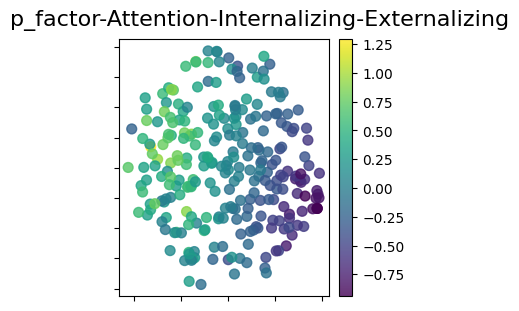

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


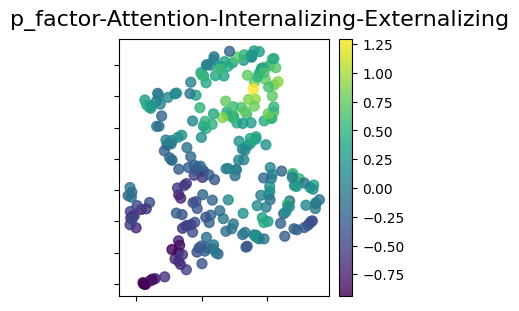

In [27]:
import umap
values = scores
color = np.mean(values, axis=1)
print(values.shape)
print(np.isnan(color).shape)
values = values[~np.isnan(color)]
color = color[~np.isnan(color)]
t_sne = manifold.TSNE(
    n_components=2,
    perplexity=100,
    init="random",
    # max_iter=250,
    random_state=0,
)
S_t_sne = t_sne.fit_transform(scores)
plot_2d(S_t_sne, color, 'p_factor-Attention-Internalizing-Externalizing')
fit = umap.UMAP()
u = fit.fit_transform(scores)
plot_2d(u, color, 'p_factor-Attention-Internalizing-Externalizing')

## K-means

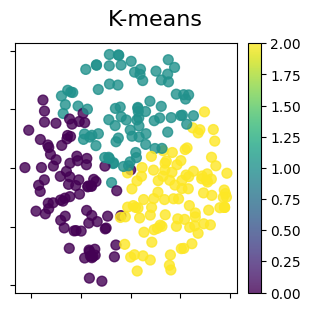

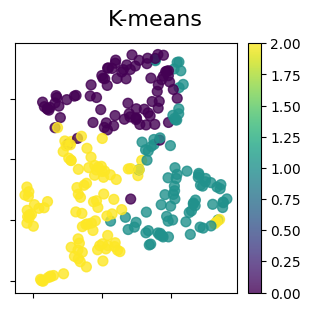

In [32]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(scores)
plot_2d(S_t_sne, kmeans.labels_, 'K-means')
plot_2d(u, kmeans.labels_, 'K-means')


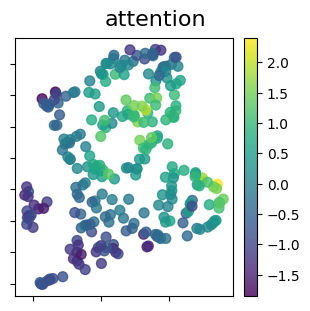

In [43]:
factor_name = 'attention'
plot_2d(u, all_ds.description[factor_name].values[~np.isnan(mean)], factor_name)

## PCA

In [16]:
from sklearn.decomposition import PCA
import numpy as np
pca = PCA(n_components=2)
pca.fit(scores)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.35640535 0.28869417]
[15.74382262 14.16958359]


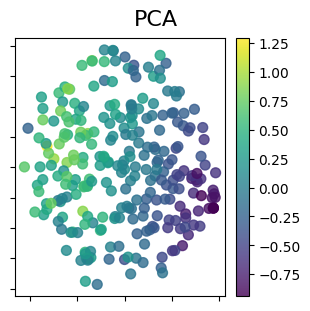

In [17]:
color = np.mean(scores, axis=1)
plot_2d(S_t_sne, color, 'PCA')

In [ ]:
from sklearn import datasets, manifold
import umap
t_sne = manifold.TSNE(
    n_components=2,
    perplexity=100,
    init="random",
    # max_iter=250,
    random_state=0,
)
%time S_t_sne = t_sne.fit_transform(embs)
fit = umap.UMAP()
%time u = fit.fit_transform(embs)